# Processing API request

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt 

from eolearn.io import SentinelHubProcessingInput, SentinelHubWCSInput
from eolearn.core import FeatureType, OverwritePermission
from sentinelhub import CRS, BBox, DataSource

import logging, sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger("eolearn.io.processing_api").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_client").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_rate_limit").setLevel(logging.DEBUG)

In [2]:
size_x = 100
size_y = 100
bbox = BBox(bbox=[268892, 4624365, 268892+size_x*10, 4624365+size_y*10], crs=CRS.UTM_33N) 
#time_interval = ('2017-12-15', '2017-12-30')
#time_interval = ('2017-12-15', '2018-1-30')
time_interval = ('2017-12-15', '2018-12-15')
maxcc = 0.8
time_difference = 60
data_source = DataSource.SENTINEL2_L2A
layer = {DataSource.SENTINEL2_L1C: 'BANDS-S2-L1C', DataSource.SENTINEL2_L2A: 'BANDS-S2-L2A'}[data_source]

In [3]:
task = SentinelHubProcessingInput(
    size_x=size_x,
    size_y=size_y,
    time_range=time_interval,
    bbox=bbox,
    bands_feature=(FeatureType.DATA, 'test_feature'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.DATA, 'SCL')],
    maxcc=maxcc,
    time_difference=time_difference,
    data_source=data_source,
    max_threads=3,
    cache_folder='test',
)

In [4]:
%%time
eopatch_proc = task.execute()

DEBUG:eolearn.io.processing_api:Downloading 86 requests of type DataSource.SENTINEL2_L2A
DEBUG:eolearn.io.processing_api:Downloading bands: [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12, dataMask, SCL]
DEBUG:eolearn.io.processing_api:Downloads complete
CPU times: user 2.42 s, sys: 344 ms, total: 2.77 s
Wall time: 8.66 s


In [5]:
proc_images = eopatch_proc[(FeatureType.DATA, 'test_feature')]
is_data = eopatch_proc[(FeatureType.MASK,'dataMask')]
#scl = eopatch_proc[(FeatureType.DATA, 'SCL')]
is_data.shape

(86, 100, 100, 1)

# Request the same image with the SentinelHubWCSInput for comparison

In [6]:
input_task = SentinelHubWCSInput(
    layer=layer,
    resx='10m',
    resy='10m',
    maxcc=maxcc,
    data_source=data_source
)

In [7]:
%%time
eopatch_wcs = input_task.execute(
    bbox=bbox,
    time_interval=time_interval
)

CPU times: user 3.12 s, sys: 299 ms, total: 3.42 s
Wall time: 8.9 s


In [8]:
wcs_images = eopatch_wcs.data[layer]

# Result comparison

In [9]:
print('WCS shape..........:', wcs_images.shape)
print('PROCESSING shape...:', proc_images.shape)

WCS shape..........: (86, 100, 100, 12)
PROCESSING shape...: (86, 100, 100, 12)


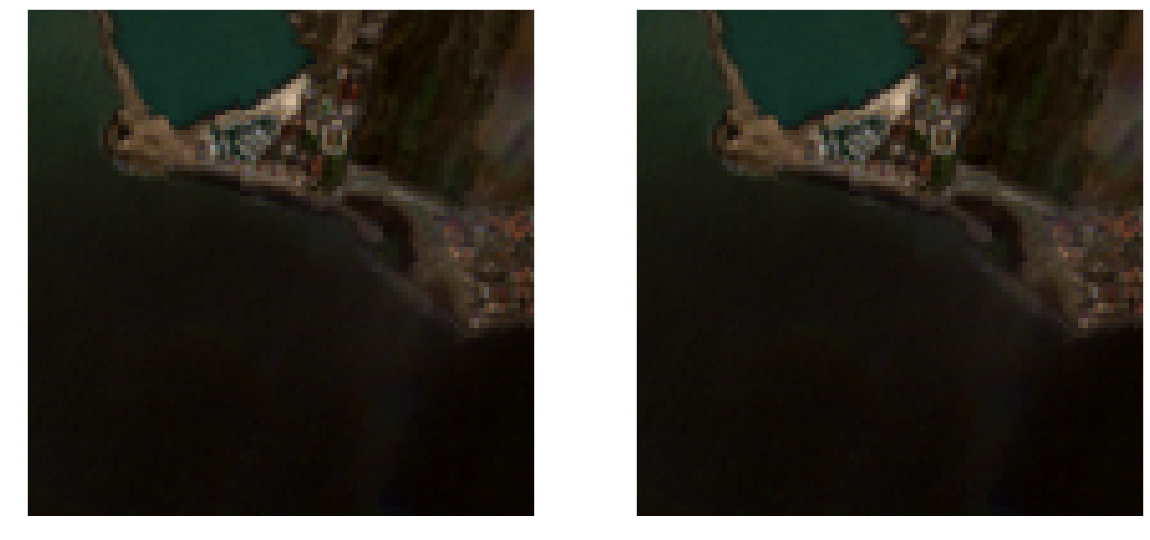

In [10]:
image_index = 0
plt.figure(figsize=(20,20))
plt.subplot2grid((1, 2), (0, 0)).imshow(proc_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);
plt.subplot2grid((1, 2), (0, 1)).imshow(wcs_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);

In [11]:
# if we round the proc_images to 4 digits, we get exactly the same array as wcs_images,
# otherwise there are some differences
proc_images = np.round(proc_images, 4)

diffs = np.abs(proc_images - wcs_images)
whr = np.where(diffs != 0)
print('Arrays equal:', np.array_equal(proc_images, wcs_images))
print('Differing values percentage: {}%'.format((proc_images[whr].size / proc_images.size) * 100))
print('Maximum difference:', np.max(diffs))
print('Mean difference:', np.mean(diffs))

Arrays equal: True
Differing values percentage: 0.0%
Maximum difference: 0.0
Mean difference: 0.0


In [12]:
proc_images[0,3,5,2], wcs_images[0,3,5,2]

(0.085, 0.085)

# 16bit vs 32 bit storage

In [39]:
eopatch_proc.save('processing_patch', compress_level=9, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [40]:
import os
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    return convert_size(total_size)

In [41]:
print('cache:', get_size('cache_dir'))
print('32bit:', get_size('processing_patch'))

cache: 0B
32bit: 334.86 KB
